# Filter SST using `GCM-filters` 

This notebook uses `GCM-filters` to filter the scalar field `SST`.

I use the `TRIPOLAR_POP_WITH_LAND` Laplacian (see example in docs [here](https://gcm-filters.readthedocs.io/en/latest/examples/example_tripole_grid.html)), as this is the only POP Laplacian currently implemented that takes into account the irregular grid cell geometries (i.e. that doesn't have a seam in the northern hemisphere midlatitudes). This Laplacian is for fixed-length filtering only (e.g. filtering out scales smaller than 100km, as shown below).

In [1]:
import gcm_filters
import xarray as xr
import numpy as np

In [2]:
gcm_filters.__version__

'0.2.3'

## Load CESM POP data

In [3]:
import intake
cat = intake.open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/CESM_POP.yaml")
ds = cat['CESM_POP_hires_control'].to_dask()

## Define arguments needed for `TRIPOLAR_POP_WITH_LAND` Laplacian

List input arguments needed

In [4]:
gcm_filters.required_grid_vars(gcm_filters.GridType.TRIPOLAR_POP_WITH_LAND)

['wet_mask', 'dxe', 'dye', 'dxn', 'dyn', 'tarea']

Define wet mask

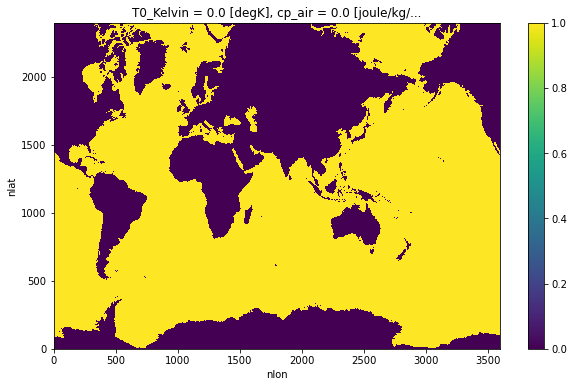

In [5]:
wet_mask = xr.where(ds['KMT']>0, 1, 0)
wet_mask.plot(figsize=(10,6), cbar_kwargs={'label': ''})

In [6]:
area = ds.TAREA  # in cm^2

In [7]:
dxe = ds.HUS  # x-spacing centered at eastern T-cell edge in cm
dye = ds.HTE  # y-spacing centered at eastern T-cell edge in cm
dxn = ds.HTN  # x-spacing centered at northern T-cell edge in cm
dyn = ds.HUW  # y-spacing centered at northern T-cell edge in cm

In [8]:
dx_min_POP = min(dxe.where(wet_mask).min(), dye.where(wet_mask).min(), dxn.where(wet_mask).min(), dyn.where(wet_mask).min())
dx_min_POP = dx_min_POP.values
dx_min_POP

array(224578.30434359)

In [9]:
specs = {
    'filter_scale': 10000000,
    'filter_shape': gcm_filters.FilterShape.GAUSSIAN,
    'dx_min': dx_min_POP
}

In [10]:
filter_tripolar_pop_with_land = gcm_filters.Filter(
    **specs,
    grid_type=gcm_filters.GridType.TRIPOLAR_POP_WITH_LAND,
    grid_vars={
        'wet_mask': wet_mask, 
        'dxe': dxe, 'dye': dye, 'dxn': dxn, 'dyn': dyn, 'tarea': area
    }
)
filter_tripolar_pop_with_land

Filter(filter_scale=10000000, dx_min=array(224578.30434359), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=49, n_iterations=1, grid_type=<GridType.TRIPOLAR_POP_WITH_LAND: 9>)

## Compute the Laplacian

First, let's take just the first time slice for a quick example.

In [11]:
sst = ds.SST.isel(time=0)
sst

<xarray.DataArray 'SST' (nlat: 2400, nlon: 3600)>
dask.array<getitem, shape=(2400, 3600), dtype=float32, chunksize=(2400, 3600), chunktype=numpy.ndarray>
Coordinates: (12/52)
    ANGLE               (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ANGLET              (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXU                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYU                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ...                  ...
    sea_ice_salinity    float64 ...
    sflux_factor        float64 ...
    sound               float64 ...
    stefan_boltzmann    float64 ...
    time                object 0046-01-02 00:00:00
    vonkar              float64 ...
Dimensions without coordinates: nlat, nlon
Attributes:
    cell_methods:  time: mean
    grid_loc:      2110
    long_name:     Surface Potential Temperature
    units:         degC

In [12]:
filtered100km_sst = filter_tripolar_pop_with_land.apply(sst, dims=['nlat', 'nlon'])

In [13]:
result = filtered100km_sst.load()

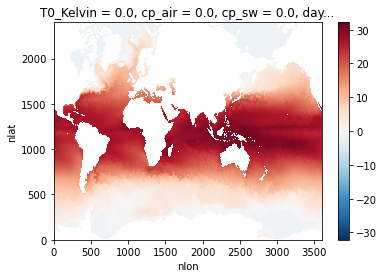

In [15]:
result.plot()

Zoom in to compare the filtered and unfiltered fields

In [18]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'SST with scales < 100km filtered out')

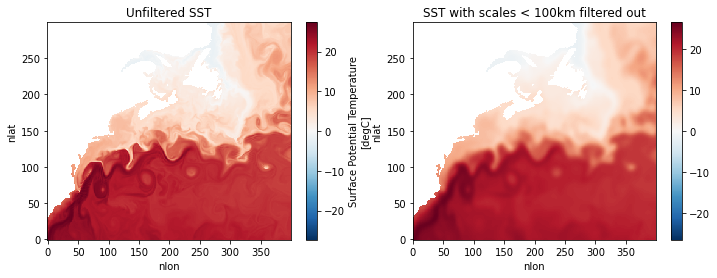

In [22]:
plt.figure(figsize=(12,4))

plt.subplot(121)
ds.SST.isel(time=0,nlon=slice(300,700),nlat=slice(1500,1800)).plot()
plt.title('Unfiltered SST')

plt.subplot(122)
result.isel(nlon=slice(300,700),nlat=slice(1500,1800)).plot()
plt.title('SST with scales < 100km filtered out')